# Generating sample paths of the Stommel Cessi model and plotting tipping time estimation results
This notebook will first generate sample paths according to the model descriptions in Ben-Yami et al. 2024. Runtime for 10000 sample paths for all models is about 5h on an Apple M1 chip. However, this part does not need to be run, as there are already sample paths available to download in the related zenodo folder (see README.md). Download and unzip `Fig3SamplePathData.zip` and copy the resulting folder `SamplePathData` to the same directory as this file. 

After generating the sample paths, the R script `AMOCestimation_altModels.Rmd` needs to be run. The files containing results of $t_c$ and the normal residuals are automatically saved in the same folder. They are also available for download in the same repository as this file.

From these results, the histograms and QQ-plots are generated.


In [23]:
import time
import os
import scipy
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.graphics.gofplots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
mpl.rcdefaults() 

plt.rcParams['pgf.texsystem'] = 'pdflatex'
plt.rcParams.update({'font.family': 'serif',
                     'text.usetex': True,
                     'font.size': 2*8,
                     'axes.labelsize': 2*8,
                     'axes.titlesize': 2*12,
                     'figure.titlesize': 2*14})


mpl.rcParams['text.latex.preamble']= r'\usepackage{amsmath}'

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#d95f02','#7570b3','#e7298a','#66a61e','#1b9e77','#e6ab02','#a6761d','#666666']) 
figlabels = ["A", "B", "C","", "D", "E", "F", ""]

## Generate sample paths of Stommel-Cessi model with various noise configurations

In [24]:
t_start = 1870+1/12 #Time series start
t_end = 2021 #Time series end

tspan = np.linspace(t_start,t_end,round((t_end-t_start)*12+1),endpoint=True) #Time array corresponding to samples
integration_permonth = 50 #Discretisation of numerical integration
integration_timestep = 1/(12*integration_permonth) #Corresponding time step
integration_tspan = np.linspace(t_start,t_end,round((t_end-t_start)*12*integration_permonth+1),endpoint=True) #Time array for numerical integration

t_0 = 1924 # Start of parameter ramping
b=0.1 # Absolute time scale of SC model
sigma_ = b**0.5*0.04 # White noise forcing strength


slowtaushift = -50 # Adjust the ramp time to simulate a fast, then slow, nonlinear parameter change

# Measurement noise strengths (start and end values of parameter ramps)
kappa_0_1 = 0.002
kappa_T_1 = 0.002
kappa_0_2 = 0.001
kappa_T_2 = 0.004
kappa_0_3 = 0.004
kappa_T_3 = 0.001

# Set parameter ramping lengths convenient for demonstration purposes. This ramp starts at t_0 and the length determines the tipping time.
tau_rs = {"sc_wn_linforc":201}

Stommel-Cessi model

In [25]:
# Model parameters are taken from Lux et al. 2022
eta2 = 7.5
epsilon_sc = 10**-2
mu_sc_0 = 5
mu_sc_c = 2/3 + 2*eta2/27 - 2/(27**0.5*eta2)*(1/3*eta2-1)**(3/2)

# Linear ramp of control parameter
def mu_sc(t, taushift = 0):
    return (mu_sc_0 - mu_sc_c)*(1-np.heaviside(t-t_0,0)*(t-t_0)/(tau_rs["sc_wn_linforc"]+taushift)) + mu_sc_c

#Stommel-Cessi model
def f_sc(xy,t, taushift=0):
    return b*np.array([epsilon_sc**-1*(-(xy[0]-1)-epsilon_sc*xy[0]*(1+eta2*(xy[0]-xy[1])**2)), mu_sc(t, taushift=taushift)-xy[1]*(1+eta2*(xy[0]-xy[1])**2)])


Integrate each of the models using the Euler(-Maruyama) method and save the paths to csv files
### Only run if you would like to make changes to the models. Data is available. Activate the respective models through the boolean variable.

In [26]:
np.random.seed(1)

samplesize = 10000
sampless = []

os.makedirs("SamplePathData/",exist_ok=True)

# Activate model runs here:
run_sc_wn_linforc   = 0
run_sc_wn_linforc_mn   = 0
run_sc_wn_slowforc = 0



samples_sc_wn_linforc = np.empty((samplesize,len(integration_tspan),))
samples_sc_wn_linforc.fill(np.nan)
samples_sc_wn_slowforc = np.empty((samplesize,len(integration_tspan),))
samples_sc_wn_slowforc.fill(np.nan)


for k in range(samplesize):
    print(k)

    if run_sc_wn_linforc:
        xy = np.empty((len(integration_tspan), 2))
        xy.fill(np.nan)
        xy[0,:] = np.array([1,1.52])
        for i in range(len(integration_tspan)-1):
            xy[i+1,:] = xy[i,:] + f_sc(xy[i,:],integration_tspan[i])*integration_timestep + np.array([sigma_,sigma_])*np.random.normal(0,1,2)*integration_timestep**0.5
            if xy[i,1]<0.5:
                print("tip_sc_linforc")
                samples_sc_wn_linforc[k,:] = xy[:,1]  
                break  
        samples_sc_wn_linforc[k,:] = xy[:,1]  

    if run_sc_wn_slowforc:
        xy = np.empty((len(integration_tspan), 2))
        xy.fill(np.nan)
        xy[0,:] = np.array([1,1.52])
        for i in range(len(integration_tspan)-1):
            xy[i+1,:] = xy[i,:] + f_sc(xy[i,:],integration_tspan[i], taushift=slowtaushift)*integration_timestep + np.array([sigma_,sigma_])*np.random.normal(0,1,2)*integration_timestep**0.5
            if xy[i,1]<0.5:
                print("tip_sc_slowforc")
                break
        samples_sc_wn_slowforc[k,:] = xy[:,1]  

np.random.seed(1)

if run_sc_wn_linforc:
    samples_sc_wn_linforc = samples_sc_wn_linforc[:,::integration_permonth]
    pd.DataFrame(np.array(samples_sc_wn_linforc).transpose()).to_csv("SamplePathData/sc_wn_linforc_1.csv")
else:
    samples_sc_wn_linforc = pd.read_csv("SamplePathData/sc_wn_linforc_1.csv", index_col=0).to_numpy().transpose()
if run_sc_wn_linforc_mn:
    samples_sc_wn_linforc = np.array(pd.read_csv("SamplePathData/sc_wn_linforc_1.csv", index_col=0)).transpose()
    measurement_noise_instance = np.random.normal(0,1,len(tspan)) * np.array([kappa_0_1*(1-np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["sc_wn_linforc"]) + kappa_T_1*np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["sc_wn_linforc"] for t in tspan])
    samples_sc_wn_linforc_mn_1 = samples_sc_wn_linforc + measurement_noise_instance
    pd.DataFrame(np.array(samples_sc_wn_linforc_mn_1).transpose()).to_csv("SamplePathData/sc_wn_linforc_mn_1.csv")
    measurement_noise_instance = np.random.normal(0,1,len(tspan)) * np.array([kappa_0_2*(1-np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["sc_wn_linforc"]) + kappa_T_2*np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["sc_wn_linforc"] for t in tspan])
    samples_sc_wn_linforc_mn_2 = samples_sc_wn_linforc + measurement_noise_instance
    pd.DataFrame(np.array(samples_sc_wn_linforc_mn_2).transpose()).to_csv("SamplePathData/sc_wn_linforc_mn_2.csv")
    measurement_noise_instance = np.random.normal(0,1,len(tspan)) * np.array([kappa_0_3*(1-np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["sc_wn_linforc"]) + kappa_T_3*np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["sc_wn_linforc"] for t in tspan])
    samples_sc_wn_linforc_mn_3 = samples_sc_wn_linforc + measurement_noise_instance
    pd.DataFrame(np.array(samples_sc_wn_linforc_mn_3).transpose()).to_csv("SamplePathData/sc_wn_linforc_mn_3.csv")
else:
    samples_sc_wn_linforc_mn_1 = pd.read_csv("SamplePathData/sc_wn_linforc_mn_1.csv", index_col=0).to_numpy().transpose()
    samples_sc_wn_linforc_mn_2 = pd.read_csv("SamplePathData/sc_wn_linforc_mn_2.csv", index_col=0).to_numpy().transpose()
    samples_sc_wn_linforc_mn_3 = pd.read_csv("SamplePathData/sc_wn_linforc_mn_3.csv", index_col=0).to_numpy().transpose()
if run_sc_wn_slowforc:
    samples_sc_wn_slowforc = samples_sc_wn_slowforc[:,::integration_permonth]
    pd.DataFrame(np.array(samples_sc_wn_slowforc).transpose()).to_csv("SamplePathData/sc_wn_slowforc_1.csv")
else:
    samples_sc_wn_slowforc = pd.read_csv("SamplePathData/sc_wn_slowforc_1.csv", index_col=0).to_numpy().transpose()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Show one of the generated samples each to see that they are visually consistent with observational AMOC data

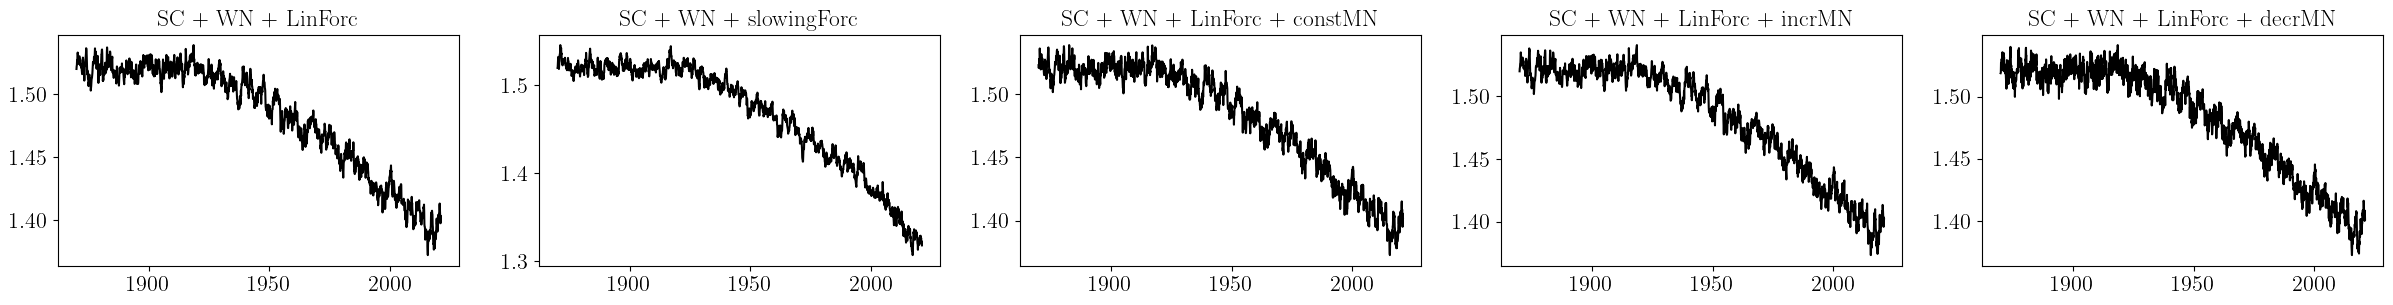

In [27]:
show_sample = 0
titles = ["SC + WN + LinForc", "SC + WN + slowingForc","SC + WN + LinForc + constMN","SC + WN + LinForc + incrMN","SC + WN + LinForc + decrMN"]
samples = [samples_sc_wn_linforc[show_sample], samples_sc_wn_slowforc[show_sample], samples_sc_wn_linforc_mn_1[show_sample], samples_sc_wn_linforc_mn_2[show_sample], samples_sc_wn_linforc_mn_3[show_sample]]
fig, axs = plt.subplots(1,len(samples), figsize=(6*len(samples),3))
for i in range(len(samples)):
    axs[i].plot(tspan, samples[i], c="black")
    axs[i].set_title(titles[i], fontsize=17)
plt.show()

## Plot results obtained from the R script
### Figure 3

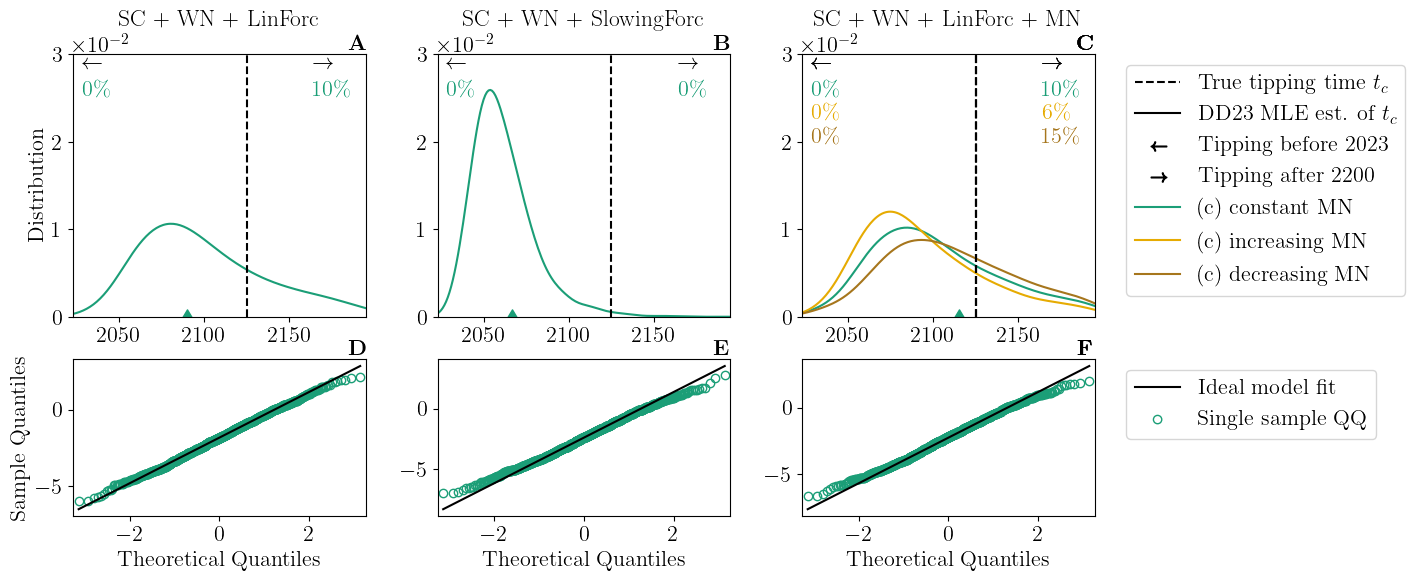

In [28]:
modelnames= ["sc_wn_linforc","sc_wn_slowforc","sc_wn_linforc_mn"]
modeldatasets = [1,1,3]
t_left = 2023
t_right = 2200
t_step = 5
modeldescrips = ["SC + WN + LinForc", "SC + WN + SlowingForc","SC + WN + LinForc + MN"]
qqsamplet0s=[2090,2067,2115]
ncols = 4
kde_disp = True
fig, axs = plt.subplots(nrows=2,ncols=ncols,figsize=(16,6),gridspec_kw={'height_ratios': [1, 0.6], 'width_ratios': [1,1,1, 0.5]})
axs=axs.flatten()
bins = np.concatenate((np.array([0]),np.arange(t_left,t_right,t_step),np.array([1e20])))
for i in range(len(modelnames)):
    for j in range(modeldatasets[i]):
        
        t_c_values = np.array(pd.read_excel("EstimMatrix_"+modelnames[i]+"_"+str(j+1)+".xlsx").loc[:,"tc"])
        samplesize = len(t_c_values)
        if kde_disp == False:
            hist = axs[i].hist(t_c_values,bins=bins,histtype="step",density=False,color=plt.rcParams['axes.prop_cycle'].by_key()['color'][4+j])[0]
            axs[i].set_ylim(0,75)
        else :
            hist = np.histogram(t_c_values,bins=bins,density=False)[0]
            t_c_values = t_c_values[np.where(t_c_values<t_right+1)]
            t_c_values = t_c_values[np.where(t_c_values>t_left-1)]
            if len(t_c_values)<=10:
                t_c_values = np.linspace(0,1,samplesize)
            kde = stats.gaussian_kde(t_c_values,0.3)
            axs[i].plot(range(t_left,t_right),kde(range(t_left,t_right))*len(t_c_values)/samplesize,color=plt.rcParams['axes.prop_cycle'].by_key()['color'][4+j])
        
        axs[i].set_ylim(0,0.03)
        axs[i].text(0.03,0.93,r"$\leftarrow$",color="black", transform=axs[i].transAxes)
        axs[i].text(0.03,0.84-j*0.09,str(round(hist[0]*100/samplesize))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][4+j], transform=axs[i].transAxes)
        axs[i].text(0.82,0.93,r"$\rightarrow$",color="black", transform=axs[i].transAxes)
        axs[i].text(0.82,0.84-j*0.09,str(round(hist[-1]*100/samplesize))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][4+j], transform=axs[i].transAxes)
        axs[i].set_xlim(t_left,t_right-t_step)
        axs[i].ticklabel_format(axis="y", style="sci", scilimits=(-1,1))
        axs[i].set_title(modeldescrips[i], fontsize = 17)
        axs[i].axvline(t_0+tau_rs["sc_wn_linforc"],color="black",linestyle="dashed")

        if j==0:
            axs[i].scatter(qqsamplet0s[i],0,marker="d",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][4],s=60)
            QQData = pd.read_csv("QQData_"+modelnames[i]+"_"+str(j+1)+".csv",index_col=0).values[:,0]
            statsmodels.graphics.gofplots.qqplot(QQData,ax=axs[i+ncols], markerfacecolor='none', markeredgecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][4])
            qqx = axs[i+ncols].lines[0].get_xdata()
            qqy = axs[i+ncols].lines[0].get_ydata()
            statsmodels.graphics.gofplots.qqline(ax=axs[i+ncols], line = "q", x = qqx, y = qqy, dist = scipy.stats.norm(),color="black")

        axs[i].text(0.94,1.015,r"$\bf "+figlabels[i]+"$",color="black", transform=axs[i].transAxes)
        axs[i+ncols].text(0.94,1.025,r"$\bf "+figlabels[i+ncols]+"$",color="black", transform=axs[i+ncols].transAxes)
    if not i == 0:
        axs[i+ncols].set_ylabel("")
axs[0].set_ylabel("Distribution")
axs[len(modelnames)].plot([0,1],[0,1],color="black",linestyle="dashed")
axs[len(modelnames)].plot([0,1],[0,1],color="black")
axs[len(modelnames)].scatter([0],[0],marker=r"$\leftarrow$",c="black")
axs[len(modelnames)].scatter([0],[0],marker=r"$\rightarrow$",c="black")
axs[len(modelnames)].plot([0,1],[0,1],color=plt.rcParams['axes.prop_cycle'].by_key()['color'][4])
axs[len(modelnames)].plot([0,1],[0,1],color=plt.rcParams['axes.prop_cycle'].by_key()['color'][5])
axs[len(modelnames)].plot([0,1],[0,1],color=plt.rcParams['axes.prop_cycle'].by_key()['color'][6])
axs[len(modelnames)].set_ylim(-1,-0.5)
axs[len(modelnames)].legend(["True tipping time $t_c$","DD23 MLE est. of $t_c$", "Tipping before "+str(t_left), "Tipping after "+str(t_right), "(c) constant MN", "(c) increasing MN", "(c) decreasing MN"],loc="upper left", bbox_to_anchor=(-0.35,1), markerscale=2)
axs[len(modelnames)].axis("off")
axs[len(modelnames)+ncols].plot([0,1],[0,1],c="black")
axs[len(modelnames)+ncols].scatter([0],[0], facecolors='none', edgecolors=plt.rcParams['axes.prop_cycle'].by_key()['color'][4])
axs[len(modelnames)+ncols].set_ylim(-1,-0.5)
axs[len(modelnames)+ncols].legend(["Ideal model fit","Single sample QQ"],loc="upper left", bbox_to_anchor=(-0.35,1))
axs[len(modelnames)+ncols].axis("off")

fig.subplots_adjust(hspace=0.2,wspace=0.28)
plt.savefig("Plots/modelsubselection_QQ" + time.strftime("%Y%m%d-%H%M%S") + ".pdf",dpi=300,bbox_inches="tight")
plt.show()